In [1]:
from nldg.utils import *
from nldg.ss import *

In [2]:
dtr = gen_data_v6(n=1000, noise_std=0.5, new_x=True)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Etr = np.array(dtr['E'])

In [3]:
# instead of cv=True, you can set lam=0.15 (or whatever reasonable value)
erm_ss = MinimaxSmoothSpline(Xtr, Ytr, Etr, cv=True, method="erm")
x_grid = np.linspace(Xtr.min(), Xtr.max(), 200)
preds_erm = erm_ss.predict(x_grid)

In [4]:
minimax_ss = MinimaxSmoothSpline(Xtr, Ytr, Etr, cv=True, method="minimax")
preds_minimax = minimax_ss.predict(x_grid)

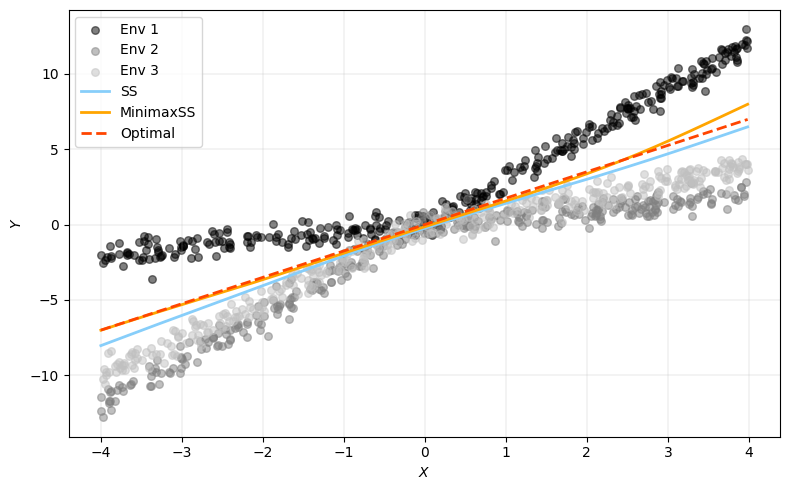

In [5]:
plot_dtr_ss(dtr, x_grid, preds_erm, preds_minimax, optfun=3)

In [6]:
fitted_erm = erm_ss.predict(Xtr)
max_mse(Ytr, fitted_erm, Etr, verbose=True)

Environment 0 MSE: 12.42360137315454
Environment 1 MSE: 5.467266429524207
Environment 2 MSE: 2.1372605990843927


np.float64(12.42360137315454)

In [7]:
fitted_minimax = minimax_ss.predict(Xtr)
max_mse(Ytr, fitted_minimax, Etr, verbose=True)

Environment 0 MSE: 8.415867241234736
Environment 1 MSE: 8.415867241247486
Environment 2 MSE: 4.414882127869086


np.float64(8.415867241247486)

In [8]:
dtr = gen_data_v7(n=1500, new_x=True)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Etr = np.array(dtr['E'])

In [9]:
erm_ss = MinimaxSmoothSpline(Xtr, Ytr, Etr, cv=True, method="erm")
x_grid = np.linspace(Xtr.min(), Xtr.max(), 200)
preds_erm = erm_ss.predict(x_grid)

In [10]:
minimax_ss = MinimaxSmoothSpline(Xtr, Ytr, Etr, cv=True, method="minimax")
preds_minimax = minimax_ss.predict(x_grid)

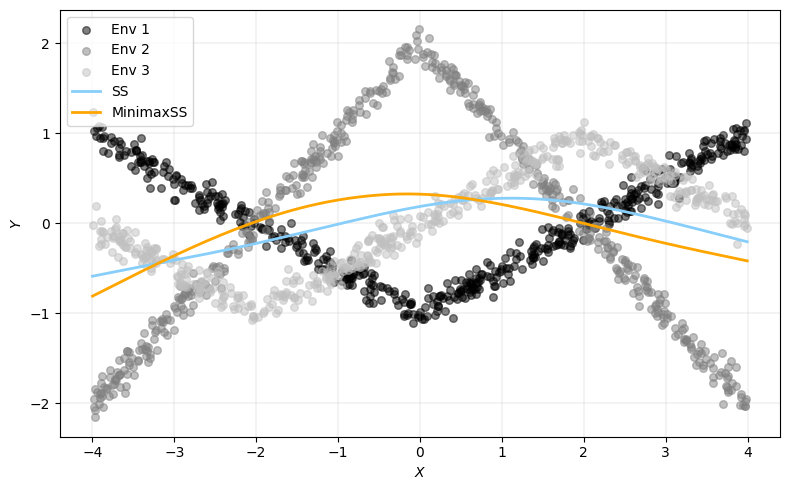

In [11]:
plot_dtr_ss(dtr, x_grid, preds_erm, preds_minimax)

In [12]:
fitted_erm = erm_ss.predict(Xtr)
max_mse(Ytr, fitted_erm, Etr, verbose=True)

Environment 0 MSE: 0.6229839404804562
Environment 1 MSE: 1.011168044708953
Environment 2 MSE: 0.19913292989675438


np.float64(1.011168044708953)

In [13]:
fitted_minimax = minimax_ss.predict(Xtr)
max_mse(Ytr, fitted_minimax, Etr, verbose=True)

Environment 0 MSE: 0.7773275475620074
Environment 1 MSE: 0.7757748983702226
Environment 2 MSE: 0.3997676386224076


np.float64(0.7773275475620074)